# Linear Regression

features: tensor([ 0.1951, -0.3244]) 
label: tensor([5.6952])


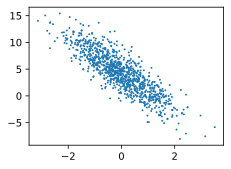

In [1]:
import random
import torch
from d2l import torch as d2l

def synthetic_data(w, b, num_examples):
    x = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(x, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return x, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

print("features:", features[0], "\nlabel:", labels[0])
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

In [6]:
def data_iter(batch_size, features, labels):
    # 样本数量
    num_examples = len(features)
    # 每个样本一个 index
    indices = list(range(num_examples))
    # 打乱 index 的顺序
    random.shuffle(indices)
    # 从 0 开始，到样本数，每次跳 batch size 大小
    for i in range(0, num_examples, batch_size):
        # 从 i 开始，到 batch size （或样本数）为止，拿出这一部分的数据
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        #产生随机顺序的 feature 和 label
        # yield 通过调用函数，返还数据
        yield features[batch_indices], labels[batch_indices]

# test
batch_size = 10
for x, y in data_iter(batch_size, features, labels):
    print(x, "\n", y)
    break

tensor([[ 0.6093,  0.6585],
        [ 0.1889, -0.0615],
        [ 1.7062, -0.1917],
        [-0.3835, -0.8491],
        [ 1.2357,  0.6139],
        [ 0.6528, -0.2308],
        [ 0.8150, -0.8205],
        [ 0.5617,  1.1571],
        [ 0.5823,  1.6087],
        [ 1.6420, -0.1751]]) 
 tensor([[ 3.1699],
        [ 4.7753],
        [ 8.2690],
        [ 6.3132],
        [ 4.5768],
        [ 6.2995],
        [ 8.6209],
        [ 1.3932],
        [-0.1140],
        [ 8.0639]])


In [39]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

def linreg(x, w, b):
    return torch.matmul(x, w) + b

def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape))**2 / 2 / batch_size

def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad
            param.grad.zero_()

In [40]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

# 每个 epoch 扫一遍数据
for epoch in range(num_epochs):
    # 每次拿出批量大小的 x 和 y
    for x, y in data_iter(batch_size, features, labels):
        # 预测并计算 loss
        l = loss(net(x, w, b), y)
        # batch 的总 loss 计算梯度
        l.sum().backward()
        # sgd 更新参数
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.003136
epoch 2, loss 0.000012
epoch 3, loss 0.000005


In [41]:
print(f'w estimate errors: {true_w - w.reshape(true_w.shape)}')
print(f'b estimate errors: {true_b - b}')

w estimate errors: tensor([ 0.0002, -0.0006], grad_fn=<SubBackward0>)
b estimate errors: tensor([0.0007], grad_fn=<RsubBackward1>)


# Linear Regression 2

In [42]:
from torch.utils import data

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [43]:
def load_array(data_array, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_array)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))

[tensor([[-0.1902, -1.8652],
         [ 0.1630, -0.5932],
         [-1.8221, -1.1409],
         [ 0.0126, -0.9002],
         [ 0.3535,  0.1944],
         [-0.7529, -0.5455],
         [-1.6451,  0.1079],
         [ 1.2175, -0.6219],
         [-0.6162,  0.8617],
         [-0.4114,  0.4615]]),
 tensor([[10.1785],
         [ 6.5416],
         [ 4.4396],
         [ 7.2919],
         [ 4.2594],
         [ 4.5449],
         [ 0.5526],
         [ 8.7346],
         [ 0.0401],
         [ 1.8276]])]

In [44]:
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

In [45]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [46]:
loss = nn.MSELoss()

In [47]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [48]:
num_epochs = 3
for epoch in range(num_epochs):
    for x, y in data_iter:
        l = loss(net(x), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000248
epoch 2, loss 0.000100
epoch 3, loss 0.000099
